# Stronthium ruthenate

In this tutorial, we analytically continue a DMFT+DFT self-energy corresponding to the material $Sr_2RuO_4$.

The DMFT calculation was performed in a maximally-localized Wannier function basis for the three Ru-4d t2g orbitals. The Wannier functions are constructed based on a non-spin-polarized DFT calculation using WIEN2k with the GGA-PBE functional, wien2wannier and Wannier90. The TRIQS/DFTTools converter for wannier90 output was used to generate the dft_input subgroup (in the h5 file).

The single-site DMFT calculation is performed with the TRIQS/DFTTools packages and added Hubbard-Kanamori interactions with a screened Coulomb repulsion U=2.3 eV and a Hund's coupling J = 0.4 eV. The impurity problem is solved on the Matsubara axis with the TRIQS/CTHYB  solver at beta = 50.0.

In [2]:
import OmegaMaxEnt_TRIQS as OT
from pytriqs.gf import *
import numpy as np
from pytriqs.plot.mpl_interface import oplot,plt  #to plot the result
from pytriqs.archive import HDFArchive as HA  #to load the data from a hdf5 file
import os
import shutil as su

Let us create a working directory to to group the output files.

In [3]:
output_dir="ouput_MaxEnt"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
os.chdir(output_dir)

Now we load the self-energy, which is in the subgroup *'DMFT_results'* and is called *'Sigma_iw'*:

In [4]:
beta=50
with HA("../Sr2RuO4/Sr2RuO4_b50_w90.h5", 'r') as A:
    S=A['DMFT_results']['Sigma_iw']

*S* is a BlockGf object, let us see what the indices of the blocks are:

In [5]:
print list(S.indices)

['down_0', 'down_1', 'down_2', 'up_0', 'up_1', 'up_2']


and the indices of the first block:

In [6]:
print list(S['down_0'].indices)

[['0'], ['0']]


Now, let us plot *S*:

In [7]:
%matplotlib notebook

<IPython.core.display.Javascript object>


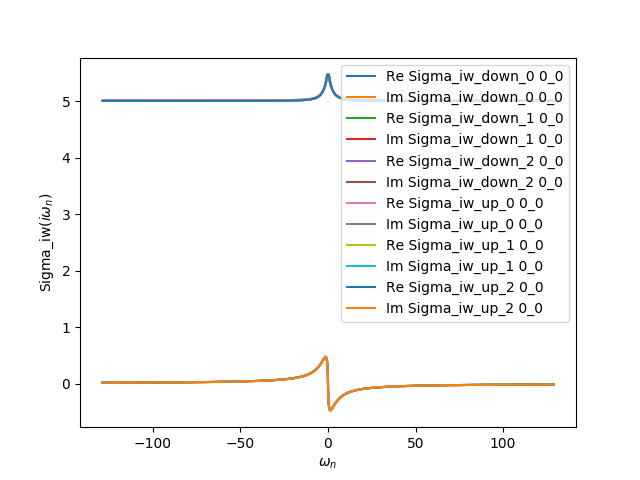

In [8]:
plt.figure(1)
oplot(S)

If we look closely, we can see that there are in fact only two distinct blocks: *down_0* and *down_1*, with *down_2* equal to *down_1* and *up_i* equal to *down_i* for *i=0,1,2*. Here we will only perform the continuation on the *down_0* component and leave the continuation of the *down_1* component as an exercise.

Note: The interactive mode of the figure must be disabled before other figures can be displayed below.

To continue the self energy, we will use the artificial Green's function method. Now, because the constant in Re$[\Sigma]$ is quite large and that constant correspond to the mean frequency of the spectrum associated to that Green's function, we will add an artificial chemical potential $\mu$ to recenter the spectrum around $\omega=0$ to make the calculation easier. We will first try $\mu=5$ since this is approximately the value of the constant in Re$\Sigma$:

In [9]:
mu=5.0
G=GfImFreq(indices=[0], mesh=S['down_0'].mesh)
G<<inverse(iOmega_n+mu-S['down_0'])

Green Function  with mesh Matsubara Freq Mesh of size 2050, Domain: Matsubara domain with beta = 50, statistic = Fermion, positive_only : 0 and target_rank 2: 

To compute the retarded Green's function, we will set *freq_step=0.01* and *spectrum_width=10*, which can be set with the first two elements of list parameter *comp_grid_params*, and set *non_uniform_grid=True* to reduce the size of the grid.

In [10]:
GR=OT.compute_GfReFreq(G, comp_grid_params=[0.01, 10], non_uniform_grid=True, interactive_mode=False)

/Users/dom2/TRIQS/install/lib/python2.7/site-packages/pytriqs/gf/gf.py:328: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dat = self._data[ self._rank * [slice(0,None)] + key_lst ]


continuation done


Now, we can obtain the retarded self-energy as $\Sigma^R(\omega)=\omega+\mu-1/G^R(\omega)$:

In [11]:
S_mu5=GfReFreq(indices=[0],mesh=GR.mesh,name="$S_{\downarrow 0, \mu5}$")
S_mu5<<Omega+mu-inverse(GR)

Green Function $S_{\downarrow 0, \mu5}$ with mesh Linear Mesh of size 65537 and target_rank 2: 

<IPython.core.display.Javascript object>


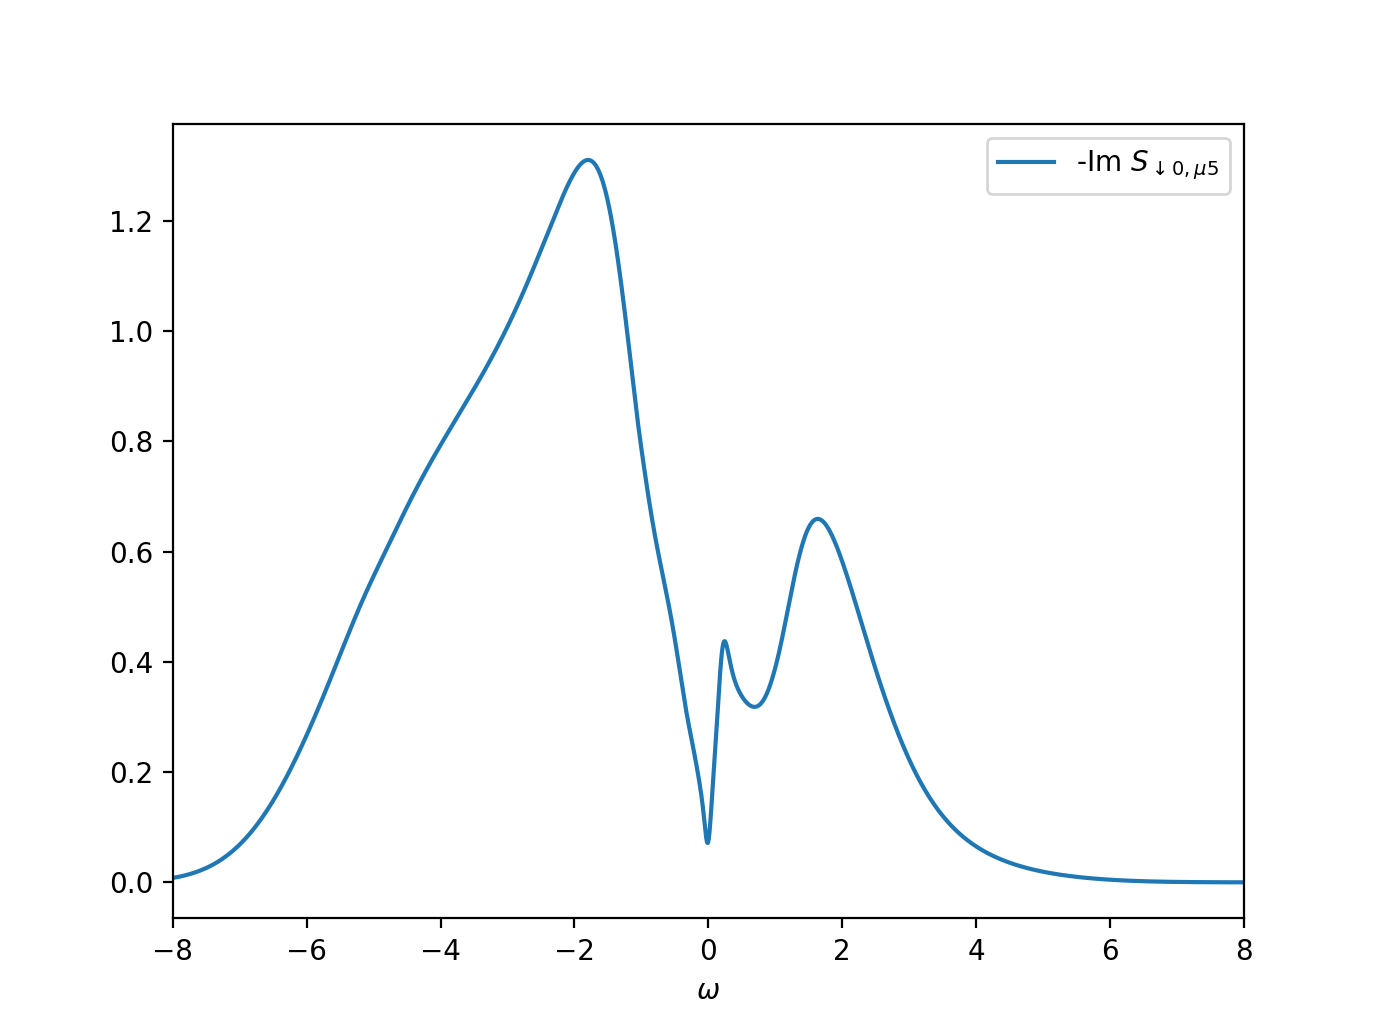

<IPython.core.display.Javascript object>


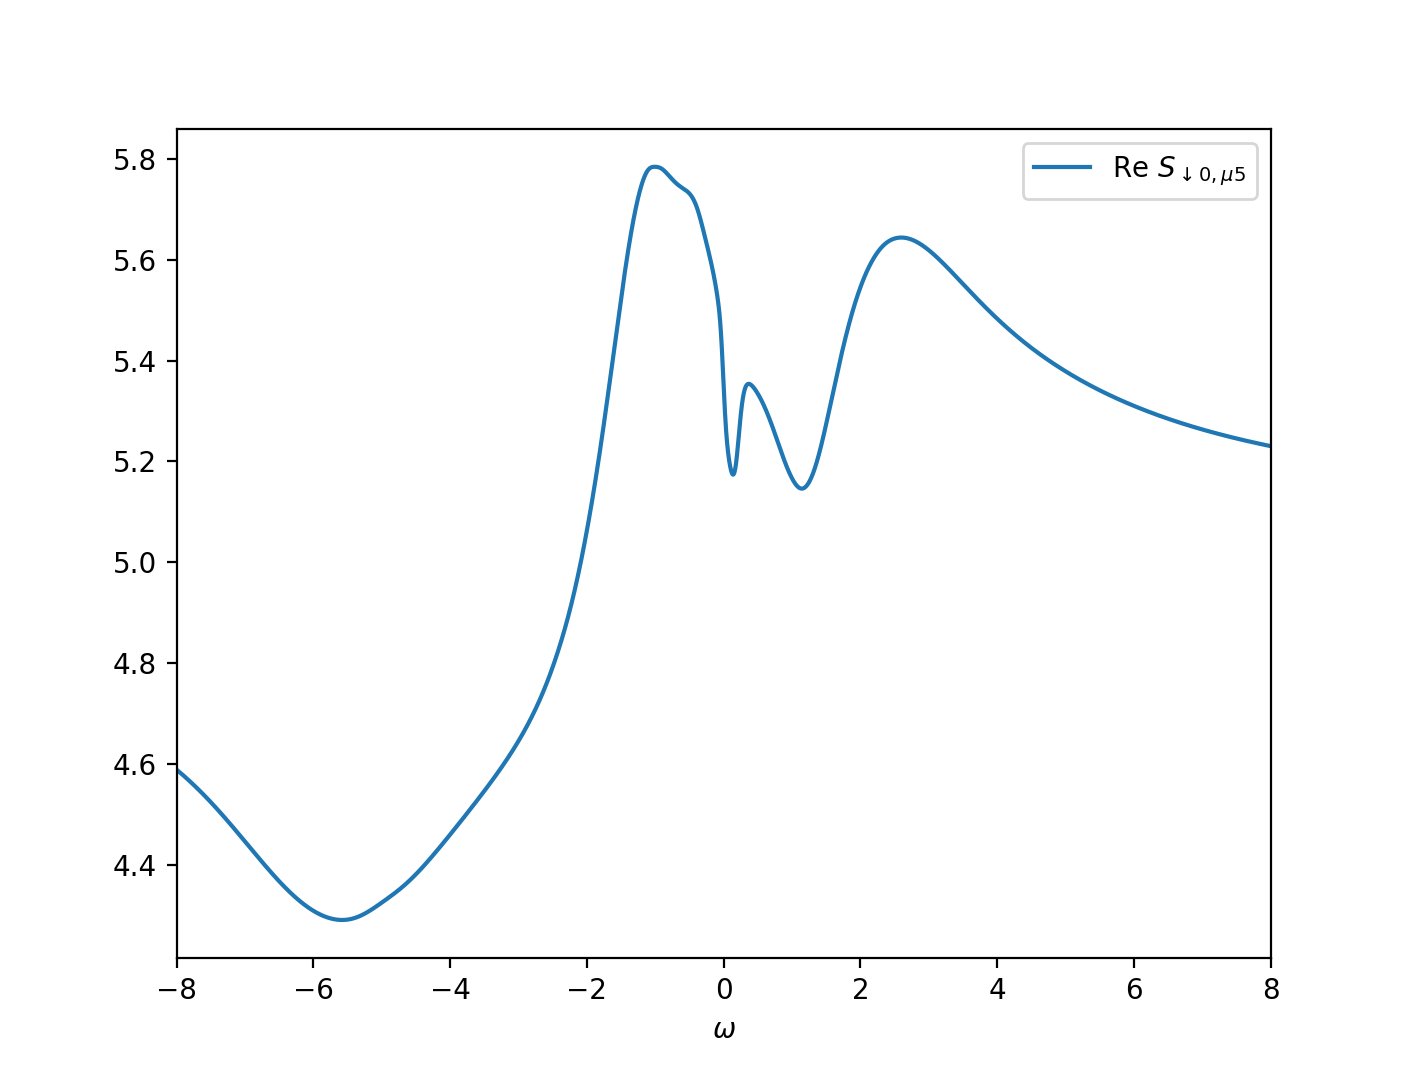

Text(0,0.5,'')

In [14]:
plt.figure(2)
oplot(-S_mu5.imag,label="-Im $S_{\downarrow 0, \mu5}$")
plt.xlim([-8,8])
plt.ylabel('')
plt.figure(3)
oplot(S_mu5.real, label="Re $S_{\downarrow 0, \mu5}$")
plt.xlim([-8,8])
plt.ylabel('')

Now, to see the effect of changing $\mu$, we can loop over a certain range of values and use a *BlockGf* to compute the results in just one call to *compute_GfReFreq()*:

In [29]:
mu_vals=np.linspace(3,7,num=5)
list_G=[]
list_names=[]
for mu in mu_vals:
    G=GfImFreq(indices=[0], mesh=S['down_0'].mesh)
    G<<inverse(iOmega_n+mu-S['down_0'])
    list_G.append(G)
    list_names.append("mu"+str(mu))

Gmu=BlockGf(name_list=list_names,block_list = list_G)

In [30]:
GR=OT.compute_GfReFreq(Gmu, comp_grid_params=[0.01, 10], non_uniform_grid=True, interactive_mode=False)

continuation done
continuation done
continuation done
continuation done
continuation done
continuation done


Now we compute $\Sigma^R(\omega)$ for each value of $\mu$ and put the result in a *BlockGf* object:

In [31]:
list_SR=[]
ind_mu=0
for bl,Gbl in GR:
    mu=mu_vals[ind_mu]
    ind_mu=ind_mu+1
    Stmp=GfReFreq(indices=[0], mesh=Gbl.mesh)
    Stmp<<Omega+mu-inverse(Gbl)
    list_SR.append(Stmp)
SR_mu=BlockGf(name_list=list_names, block_list=list_SR, name ="$S^R$")

Finally, we plot the results for all values of $\mu$:

In [32]:
%matplotlib notebook

<IPython.core.display.Javascript object>


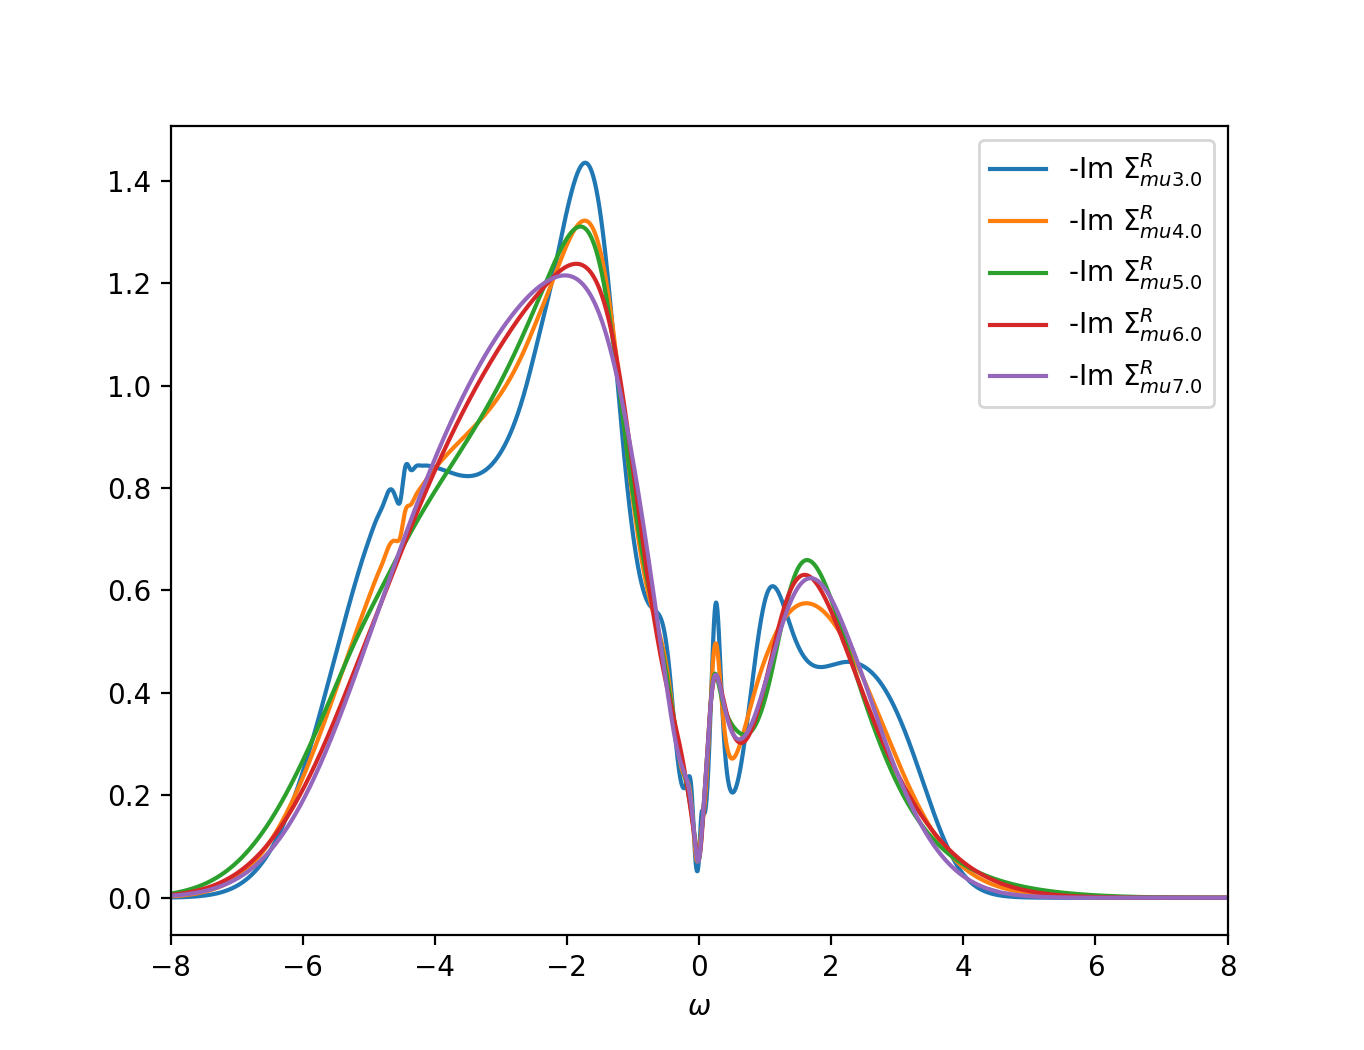

<IPython.core.display.Javascript object>


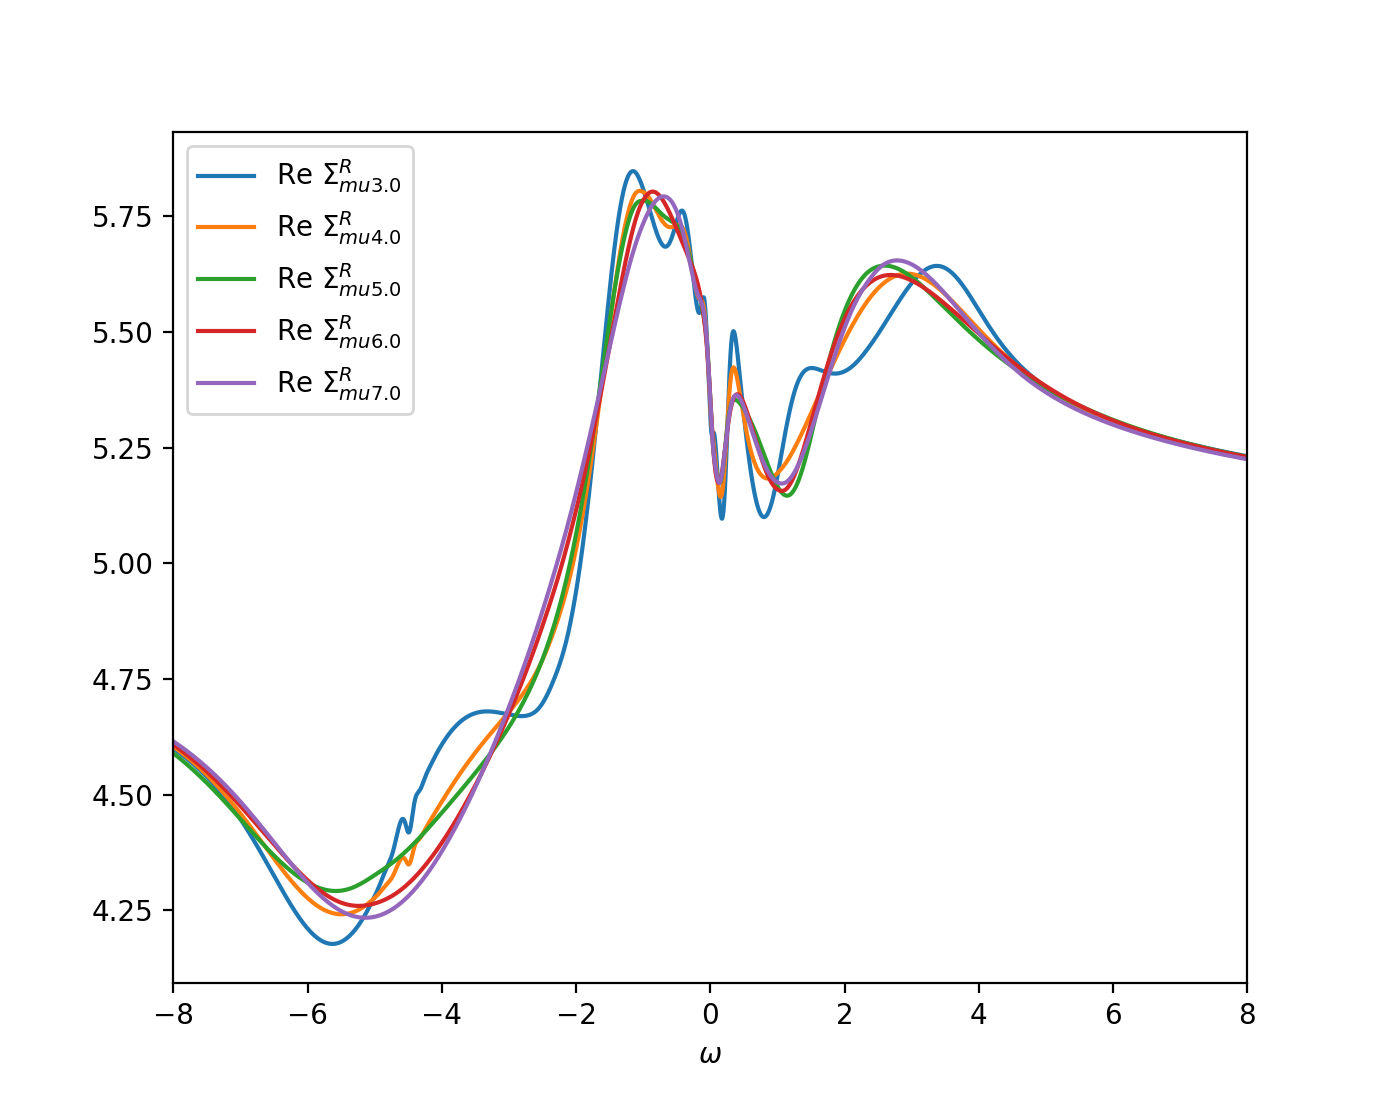

Text(0,0.5,'')

In [68]:
plt.figure(4)
for ind in list_names:
    lbl="-Im $\Sigma^R_{"+ind+"}$"
    oplot(-SR_mu[ind].imag,label=lbl)
plt.xlim([-8,8])
plt.legend()
plt.ylabel('')
plt.figure(5)
for ind in list_names:
    lbl="Re $\Sigma^R_{"+ind+"}$"
    oplot(SR_mu[ind].real,label=lbl)
plt.xlim([-8,8])
plt.legend()
plt.ylabel('')

We can see that the results are the most stable between $\mu=5$ and $\mu=7$.

In [66]:
os.chdir("..")
su.rmtree(output_dir)

## Exercise

Perform the calculation of $\Sigma^R(\omega)$ for the *down_1* component.